<a href="https://www.kaggle.com/code/samithsachidanandan/indian-bird-species-detection-cnn?scriptVersionId=291829007" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [27]:
!pip install protobuf==3.20.3

# Import Libraries

In [28]:
import numpy as np 
import pandas as pd 
import os 
import seaborn as sns 
import matplotlib.pyplot as plt 
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")


import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import VGG16


# Loading the Data

In [29]:


train_dir = Path('/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path('/kaggle/input/indian-bird-species-dataset-traintest-split/Birds25_Split/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [30]:
def proc_img(filepath):
  

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

   
    df = pd.concat([filepath, labels], axis=1)

 
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)

In [31]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')


-- Training set --

Number of pictures: 25916

Number of different labels: 25

Labels: ['Rufous_Treepie' 'Northern_Lapwing' 'White_Breasted_Kingfisher'
 'Ruddy_Shelduck' 'Sarus_Crane' 'Common_Kingfisher' 'Hoopoe' 'Common_Myna'
 'Common_Rosefinch' 'Asian_Green_Bee_eater' 'Indian_Roller'
 'Coppersmith_Barbet' 'Brown_Headed_Barbet' 'White_Breasted_Waterhen'
 'Common_Tailorbird' 'Indian_Grey_Hornbill' 'Gray_Wagtail' 'House_Crow'
 'Indian_Peacock' 'Jungle_Babbler' 'Cattle_Egret' 'White_Wagtail'
 'Forest_Wagtail' 'Red_Wattled_Lapwing' 'Indian_Pitta']


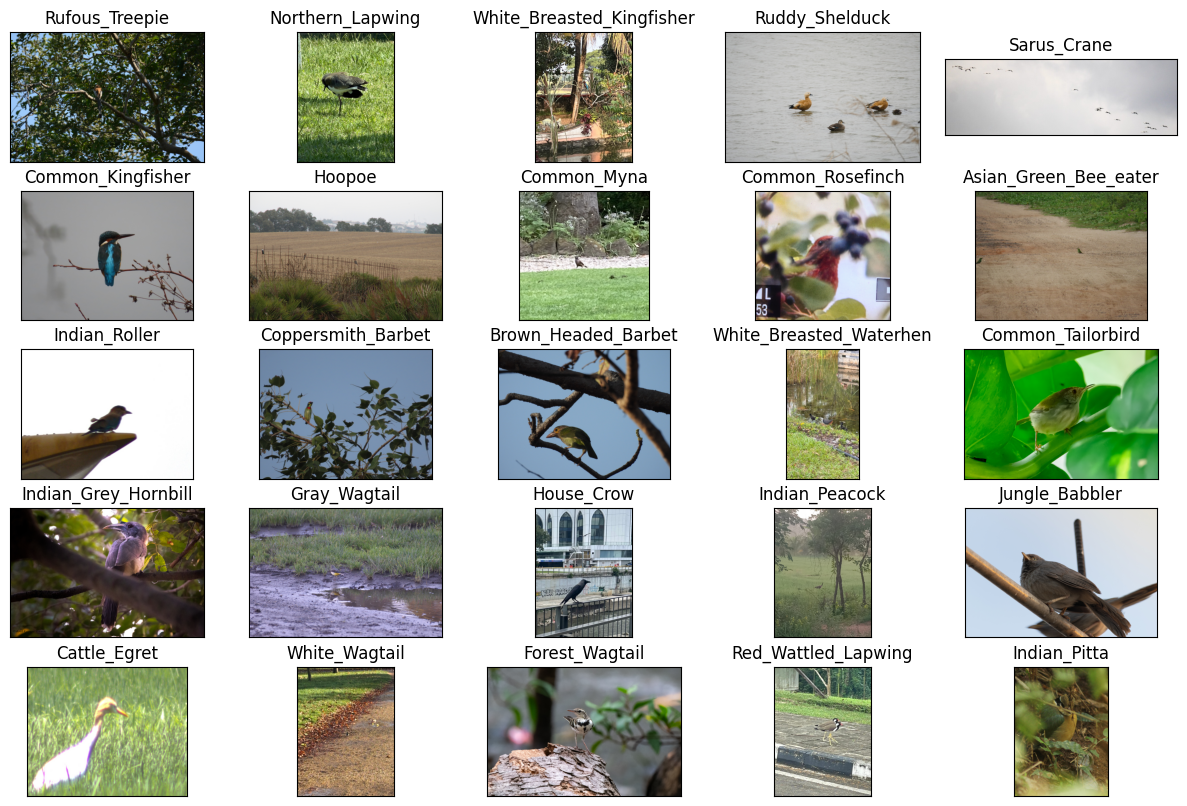

In [32]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()


fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

# Config

In [33]:
IMG_SIZE = (128, 128)  
BATCH_SIZE = 8
SEED = 42
VAL_SPLIT = 0.2


# Train- Val - Test Split

In [34]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical',  
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training"
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode='categorical', 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation"
)

test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode='categorical', 
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 29556 files belonging to 25 classes.
Using 23645 files for training.
Found 29556 files belonging to 25 classes.
Using 5911 files for validation.
Found 7402 files belonging to 25 classes.


In [35]:
class_names = train_ds_raw.class_names
num_classes = len(class_names)

In [36]:
batch = next(train_ds_raw.as_numpy_iterator())

In [37]:
batch[0].shape

(8, 128, 128, 3)

In [38]:
class_names = train_ds_raw.class_names
print(class_names)

['Asian_Green_Bee_eater', 'Brown_Headed_Barbet', 'Cattle_Egret', 'Common_Kingfisher', 'Common_Myna', 'Common_Rosefinch', 'Common_Tailorbird', 'Coppersmith_Barbet', 'Forest_Wagtail', 'Gray_Wagtail', 'Hoopoe', 'House_Crow', 'Indian_Grey_Hornbill', 'Indian_Peacock', 'Indian_Pitta', 'Indian_Roller', 'Jungle_Babbler', 'Northern_Lapwing', 'Red_Wattled_Lapwing', 'Ruddy_Shelduck', 'Rufous_Treepie', 'Sarus_Crane', 'White_Breasted_Kingfisher', 'White_Breasted_Waterhen', 'White_Wagtail']


# Normalization

In [39]:
train_ds = train_ds_raw.map(lambda x, y: (x/255,y))
test_ds = test_ds_raw.map(lambda x, y: (x/255,y))
val_ds = val_ds_raw.map(lambda x, y: (x/255,y))

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# Model

In [41]:


# input_shape = batch[0].shape[1:]


# model = models.Sequential([
#     layers.Input(shape=input_shape),
    

#     layers.RandomFlip("horizontal"),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
    

#     layers.Conv2D(32, (3, 3), padding="same"),
#     layers.ReLU(),
#     layers.BatchNormalization(),
#     layers.Conv2D(32, (3, 3), padding="same"),
#     layers.ReLU(),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.1),
    
  
#     layers.Conv2D(64, (3, 3), padding="same"),
#     layers.ReLU(),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.1),
    
  
#     layers.Conv2D(128, (3, 3), padding="same"),
#     layers.ReLU(),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.1),
    

#     layers.GlobalAveragePooling2D(),
#     layers.Dense(256),
#     layers.ReLU(),
#     layers.BatchNormalization(),
#     layers.Dropout(0.4),
#     layers.Dense(128),
#     layers.ReLU(),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(num_classes, activation="softmax")
# ])

In [42]:
base_model = VGG16(
    weights='imagenet',
    input_shape=(128, 128, 3),
    include_top=False
)


base_model.trainable = False


model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    
   
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomBrightness(0.2),
    
 
    base_model,
    

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(num_classes, activation='softmax')
])


In [43]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness_1             │ (None, 128, 128, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,148,377 (57.79 MB)

 Trainable params: 431,897 (1.65 MB)

 Non-trainable params: 14,716,480 (56.14 MB)

In [44]:
# model.compile(
#     optimizer=Adam(learning_rate=0.001),
#     loss='categorical_crossentropy', 
#     metrics=['accuracy']
# )

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [45]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

In [46]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Training 

In [47]:
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 104s 34ms/step - accuracy: 0.0417 - loss: 3.6379 - val_accuracy: 0.0721 - val_loss: 3.0971 - learning_rate: 0.0010
Epoch 2/50
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - accuracy: 0.0558 - loss: 3.2337 - val_accuracy: 0.0851 - val_loss: 3.0168 - learning_rate: 0.0010
Epoch 3/50
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 74s 25ms/step - accuracy: 0.0606 - loss: 3.1829 - val_accuracy: 0.0795 - val_loss: 3.0122 - learning_rate: 0.0010
Epoch 4/50
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 74s 25ms/step - accuracy: 0.0645 - loss: 3.1583 - val_accuracy: 0.1025 - val_loss: 2.9490 - learning_rate: 0.0010
Epoch 5/50
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 74s 25ms/step - accuracy: 0.0657 - loss: 3.1535 - val_accuracy: 0.1130 - val_loss: 2.9191 - learning_rate: 0.0010
Epoch 6/50
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - accuracy: 0.0666 - loss: 3.1454 - val_accuracy: 0.1147 - val_loss: 2.9140 - learning_rate: 0.0010
Epoch 7/50
2956/2956 ━━━━━━━━━━━━━━━━━━━━ 73s 25ms/step - accur

In [48]:
# history = model.fit(
#     train_ds,
#     epochs=50,
#     validation_data=val_ds,
#     callbacks=[early_stopping, reduce_lr],
#     verbose=1
# )

In [49]:
scores = model.evaluate(test_ds)

926/926 ━━━━━━━━━━━━━━━━━━━━ 24s 26ms/step - accuracy: 0.1222 - loss: 2.8360


In [50]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 12.65%


# Results

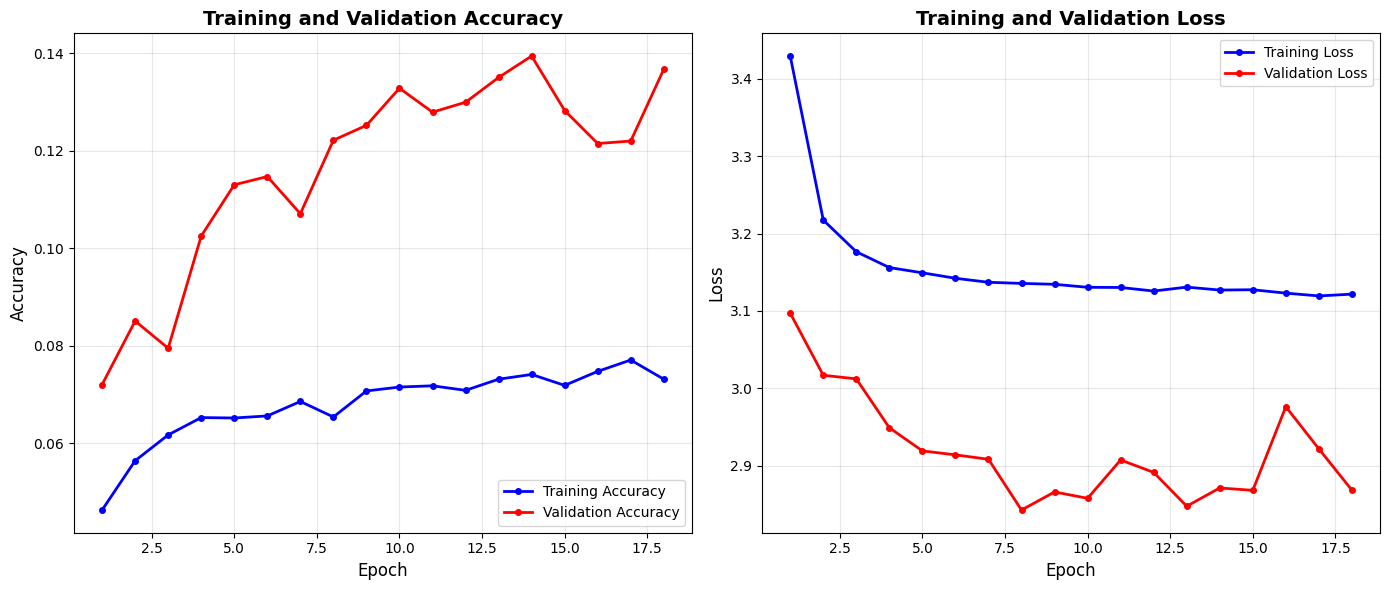


Training Summary:
Total epochs trained: 18
Best validation accuracy: 0.1394 (Epoch 14)
Final training accuracy: 0.0732
Final validation accuracy: 0.1367
Final training loss: 3.1217
Final validation loss: 2.8683



In [51]:
def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)

# Saving the Model

In [52]:
model.save('bird_classiifer.keras')